**Student Name**: Chandresh J Sutariya

**Student Roll No**: 21f3001415

#1 Hierarchical Reinforcement Learning

For this assignment, we will be referring to Sutton, Precup and Singh’s 1999 paper, ‘Between MDPs and semi-MDPs : A Framework for Temporal Abstraction in Reinforcement Learning’. Please read the paper upto and including Section 3, it is self explanatory and a
good reference leading up to the understanding and implementation of SMDP Q-learning. Section 3 of the paper talks about SMDP planning and is necessary to build intuition to solve this assignment. We will be working with a simple taxi domain environment (explained
in the next section). Your tasks are to implement 1-step SMDP Q-Learning and intra-option Q-Learning on this environment.

#2 Environment Description
The environment for this task is the taxi domain, illustrated in Fig. 1. It is a 5x5 matrix, where each cell is a position your taxi can stay at. There is a single passenger who can be either picked up or dropped off, or is being transported. There are four designated
locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the
passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.


Passenger locations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue); 4: in taxi Destinations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue)
Rewards:
 - -1 per step unless other reward is triggered.
 -  +20 delivering passenger.
 - -10 executing ”pickup” and ”drop-off” actions illegally.
The discount factor is taken to be γ = 0.9.

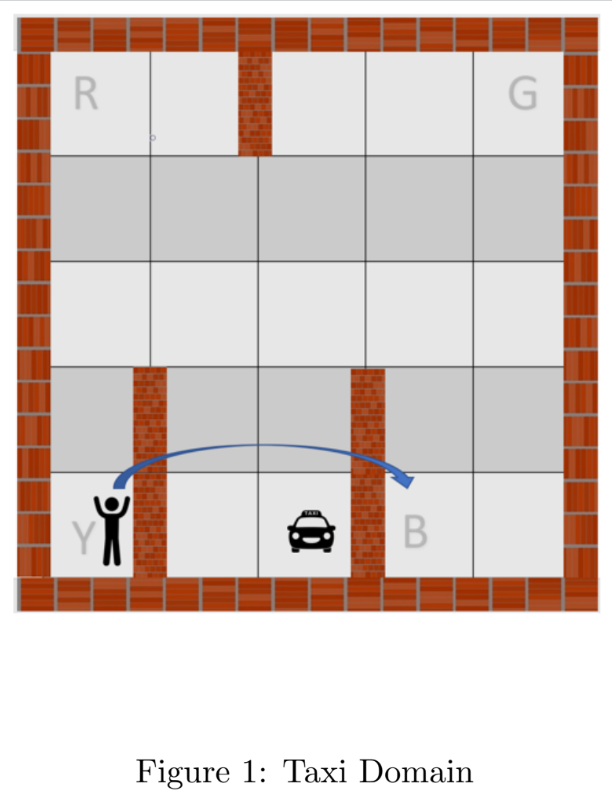

#3 Actions and Options
**Actions:** There are 6 discrete deterministic actions: 0: move south; 1: move north; 2: move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.


**Options:** Options to move the taxi to each of the four designated locations, executable when the taxi is not already there.


You will be experimenting with OpenAI Gym’s Taxi-v3 environment.

# 4 Tasks
First, implement the single step **SMDP Q-learning** for solving the taxi problem. A rough sketch of the algorithm is as follows: Given the set of options,

- Execute the current selected option to termination (e.g. use epsilon greedy $Q(s, o))$.
- Computer $r(s, o)$.
- Update $Q(st, o)$.

Second, implement **intra-option Q-Learning** on the same environment.


For each algorithm, do the following (only for the configuration with the best hyperparameters):

1. Plot reward curves and visualize the learned Q-values.
2. Provide a written description of the policies learnt and your reasoning behind why
the respective algorithm learns the policy.

3. Is there an alternate set of options that you can use to solve this problem, such that this set and the given options to move the taxi are mutually exclusive? If so, run both algorithms with this alternate set of options and compare performance with the algorithms run on the options to move the taxi.


Finally, provide a comparison between the SMDP Q-Learning and intra-option Q-Learning algorithms. Do you observe any improvement with intra-option Q-Learning? If so, describe why this happens as well. Please make sure that all descriptions are brief and to the point.

# 5 Submission Instructions
You are required to submit both your report and your code. Zip your code (a colab/jupyter notebook ipynb file) and report (a pdf file) together and submit.

# THE CODE:

In [45]:
#@title installation/s and imports
!pip install gym --quiet
import gym
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## env. setup

In [46]:
env = gym.make('Taxi-v3');

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Defining options:

AS THE "EXPLICITE" OPTIONS ARE NOT GIVE IN THE PROBLEM STATEMENT BUT THE INSTUCTION ARE GIVEN AS - defining option to MOVE the taxi to each of the 4 designated locations, executable when the taxi is not there - I AM DEFININT THE OPTIONS AS FOLLOWS:

In [47]:
#@title : defining options
import numpy as np

#option taking to R
option_for_R = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])
#option taking to G
option_for_G = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])
#option taking to Y
option_for_Y = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ])
#option taking to B
option_for_B = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ])
policyOpt = [option_for_R,option_for_G,option_for_Y,option_for_B]
option_num = 4

## Task 1 : SMDP Q-learning

### Learning parameters

In [48]:
#@title : definining epsilon greedy
import random

def egreedy(q_values,s,eps):
  if q_values[s].any() and random.random() > eps: # exploit
    return np.argmax(q_values[s])
  else:# explore
    choice = random.randint(0,q_values.shape[-1]-1)
    return choice

In [49]:
#@title : selecting next action according to option

# defining goal state
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}

# defining Option function to select option according to current state and q-table
def Option(env, state, goal_number, Q_table, eps=0.1, goal = goal) -> list[int,bool]:
  on_terminal = False
  x,y,pas,drop=env.decode(state)

  # if agent has reached the goal:
  if (x==goal[goal_number][0] and y==goal[goal_number][1]):
      # terminating option
      on_terminal = True

      # if passanget == goal: pickup the passanger
      if pas == goal_number:
        option_action = 4
      # if drop == goal: drop the pas.
      elif drop == goal_number:
        option_action = 5
      # else: go north if: at bottom most row; else: go soth ( as you will be on top most row then )
      else:
        option_action = 1 if (goal_number in [0,1]) else 0
  else:
    # else: select next action accouding the option's q-table
    option_action = egreedy(Q_table[goal_number], 5*x+y, eps=eps)
  return [option_action,on_terminal]

In [50]:
#Q-values for each option
Qopt = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(option_num)}
Qopt;

In [51]:
#@title : iterating episodes

# nPas = 5; nDrop = 4
passanger_actions = 5; destination_actions = 4
q_values_SMDP = np.zeros((passanger_actions*destination_actions,option_num))
# print(q_values_SMDP)
updated_SMDP = np.zeros((passanger_actions*destination_actions,option_num))
# print(updated_SMDP)

reward_list = []

#Q-values for each option
# Qopt = option_Q_value
option_Q_value = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(option_num)}
eps = {i:0.01 for i in range(option_num)}

gamma, alpha = 0.9, 0.1

eps_min, eps_decay, eps_main, count = 0.01, 0.99, 0.5, 0

episodes = 1500

# episodes
for i in range(episodes):
    #initializing total reward for each iteration to zero
    total_reward = 0
    state = env.reset()
    on_terminal = False

    # While terminal state is not reached
    while not on_terminal:

        # Choose action
        x,y,pas,drop = env.decode(state)
        subState = destination_actions*pas+drop
        option = egreedy(q_values_SMDP, subState, eps=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)

        #initializing reward for each option to zero
        reward_bar = 0
        #optdone = option_done
        option_done = False
        move = 0
        prev = state

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        option_done = False
        while not option_done and not on_terminal:
          optact,option_done = Option(env, state,option,option_Q_value,eps[option])

          [x,y,_,_]=  list(env.decode(state))

          next_state, reward, on_terminal,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state))
          reward_bar = gamma*reward_bar + reward
          # counting moves to make update in SMDP
          move += 1
          total_reward+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          total_reward+=reward
          reward_surr = reward
          if option_done:
            reward_surr = 20
          if optact<4:
            option_Q_value[option][5*x+y, optact] = option_Q_value[option][5*x+y, optact] + \
                                        alpha*(reward_surr + gamma*np.max(option_Q_value[option][5*x1+y1, :]) - option_Q_value[option][5*x+y, optact])
          state = next_state

        _,_,pas,drop = env.decode(state)
        subState = destination_actions*pas+drop

        _,_,pas,drop = env.decode(prev)
        subPrev = destination_actions*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + \
                                            (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updated_SMDP[subPrev, option] += 1
    reward_list.append(total_reward)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (1479/1500) = 98.6%


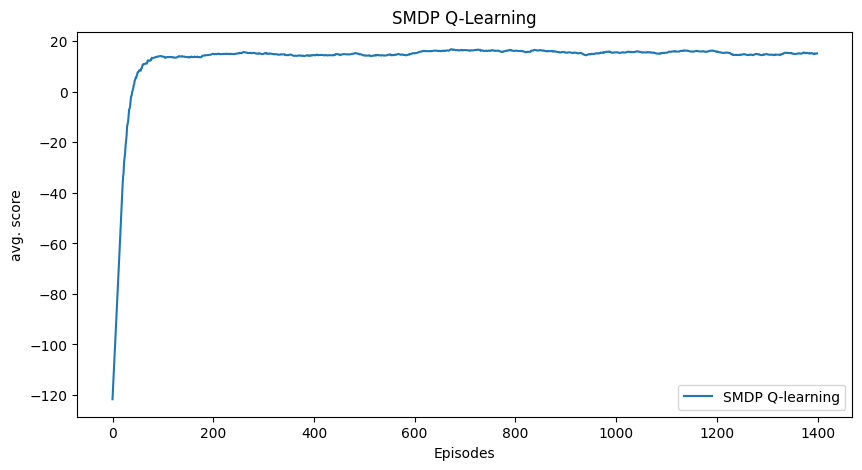

In [52]:
#@title : plotting iteration vs avg. reward : while learning
plt.figure(figsize = (10,5))
# averaging rewards for last 100 iterations
# 0 to 100 @ 100, 1 to 101 @ 101 ,..., 1400 to 1500 @ 1500
avg_rews1 = [np.average(reward_list[i:i+100]) for i in range(len(reward_list)-100)]
plt.plot(avg_rews1,label = 'SMDP Q-learning')
plt.xlabel('Episodes')
plt.ylabel('avg. score')
plt.title('SMDP Q-Learning')
plt.legend()

### Learned parameters

In [53]:
#@title : updated SMDP Q-values : selection option
q_values_SMDP

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.40817284, -3.77530303, -3.92807993, -3.78385785],
       [ 4.08565217, -4.48385108, -5.74504409, -4.54960093],
       [ 5.85359058, -2.7573139 , -2.94180818, -2.79966701],
       [-3.38557616,  3.62847177, -2.66745741, -2.59581858],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-2.05894567,  4.69178462, -2.43255638, -2.06083981],
       [-3.88810025,  5.59717239, -3.82087966, -4.96360633],
       [-3.8889545 , -2.10399393,  4.9868495 , -1.89784438],
       [-3.07777781, -3.17922841,  3.51607298, -3.0983241 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-2.36963814, -2.75718073,  3.96772795, -2.72140582],
       [-1.89995952, -2.39296216, -1.77465439,  5.34771644],
       [-2.12011467, -3.32749133, -2.1394417 ,  4.7234351 ],
       [-2.31961216, -2.57191019, -4.27231745,  3.74264285],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [15.40060473, -1.

In [54]:
#@title : updated option_Q_value : selection action from an option
option_Q_value

{0: array([[ 0.        , 76.54197181,  0.        ,  0.        ],
        [-0.1       , -0.1       , -0.1       , 52.4500337 ],
        [23.79653925, -1.82093062, -1.79562743, -1.82093062],
        [ 9.88116887, -1.97969939, -2.05567516, -2.02256406],
        [26.61042514, -0.73619385, -2.37449615, -2.38093143],
        [ 9.48967743, 67.88680997,  1.78539831, 14.74434104],
        [-0.32158386, -0.22540438, -0.29701   , 48.26673097],
        [40.19739061, -1.03258271, -1.59283178,  1.73487319],
        [-1.78283   , -1.76593466,  0.9295885 , 28.96947558],
        [30.82098212, -2.09552978,  0.43546866, -0.57023051],
        [ 7.62311377, 60.09092736,  3.98198626, 17.12024684],
        [ 3.10613756,  3.51245411,  6.84045126, 53.05245012],
        [-1.24129811,  2.35903898,  2.4558595 , 46.65167209],
        [-1.60341722, -1.64511223,  4.27896061, 40.83254299],
        [-1.48167264, -1.88954173,  1.11391993, 35.53621051],
        [-0.72665081, 52.52211919, -0.67934652,  2.95089623],
     

### Score/reward on learned parameters

In [55]:
#@title : Iterating on LEARNED parameters

# nPas = 5; nDrop = 4
passanger_actions = 5; destination_actions = 4
#######################################################################
# using learned SMDP-Q-value in above 1500 interations
#######################################################################
q_values_SMDP = updated_SMDP
# print(q_values_SMDP)
# updated_SMDP = np.zeros((passanger_actions*destination_actions,option_num))
# print(updated_SMDP)


#Q-values for each option
# Qopt = option_Q_value
#######################################################################
# using learned option_Q_values in above 1500 iterations: not making any updates here
######################################################################
# option_Q_value = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(option_num)}

reward_list = []


eps = {i:0.01 for i in range(option_num)}

gamma, alpha = 0.9, 0.1

eps_min, eps_decay, eps_main, count = 0.01, 0.99, 0.5, 0

episodes = 1500

# episodes
for i in range(episodes):
    #initializing total reward for each iteration to zero
    total_reward = 0
    state = env.reset()
    on_terminal = False

    # While terminal state is not reached
    while not on_terminal:

        # Choose action
        x,y,pas,drop = env.decode(state)
        subState = destination_actions*pas+drop
        option = egreedy(q_values_SMDP, subState, eps=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)

        #initializing reward for each option to zero
        reward_bar = 0
        #optdone = option_done
        option_done = False
        move = 0
        prev = state

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        option_done = False
        while not option_done and not on_terminal:
          optact,option_done = Option(env, state,option,option_Q_value,eps[option])

          [x,y,_,_]=  list(env.decode(state))

          next_state, reward, on_terminal,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state))
          reward_bar = gamma*reward_bar + reward
          # counting moves to make update in SMDP
          move += 1
          total_reward+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          total_reward+=reward
          reward_surr = reward
          if option_done:
            reward_surr = 20
          if optact<4:
            # option_Q_value[option][5*x+y, optact] = option_Q_value[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(option_Q_value[option][5*x1+y1, :]) - option_Q_value[option][5*x+y, optact])\
            pass

          state = next_state

        _,_,pas,drop = env.decode(state)
        subState = destination_actions*pas+drop

        _,_,pas,drop = env.decode(prev)
        subPrev = destination_actions*pas+drop

        # q_values_SMDP[subPrev, option] += alpha*(reward_bar + \
        #                                     (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        # updated_SMDP[subPrev, option] += 1
    reward_list.append(total_reward)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (1500/1500) = 100.0%


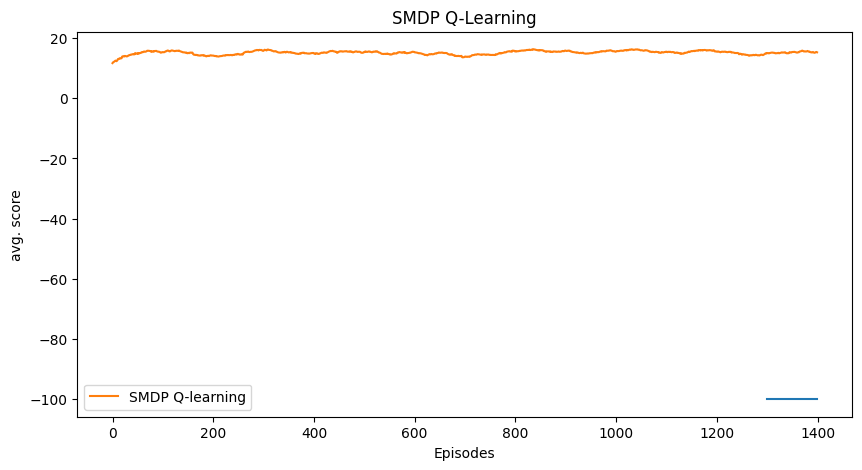

In [56]:
#@title : plotting iteration vs avg. reward (On LEARNED parameters)
plt.figure(figsize = (10,5))
# averaging rewards for last 100 iterations
# 0 to 100 @ 100, 1 to 101 @ 101 ,..., 1400 to 1500 @ 1500
avg_rews1_1 = [np.average(reward_list[i:i+100]) for i in range(len(reward_list)-100)]
X = [i for i in range(len(avg_rews1)-100,len(avg_rews1))]
plt.plot(X,[-100 for i in range(100)])

plt.plot(avg_rews1_1,label = 'SMDP Q-learning')
plt.xlabel('Episodes')
plt.ylabel('avg. score')
plt.title('SMDP Q-Learning')
plt.legend()

### Visualizing Learned policy

Text(0.5, 1.0, 'Policy learnt by SMDP')

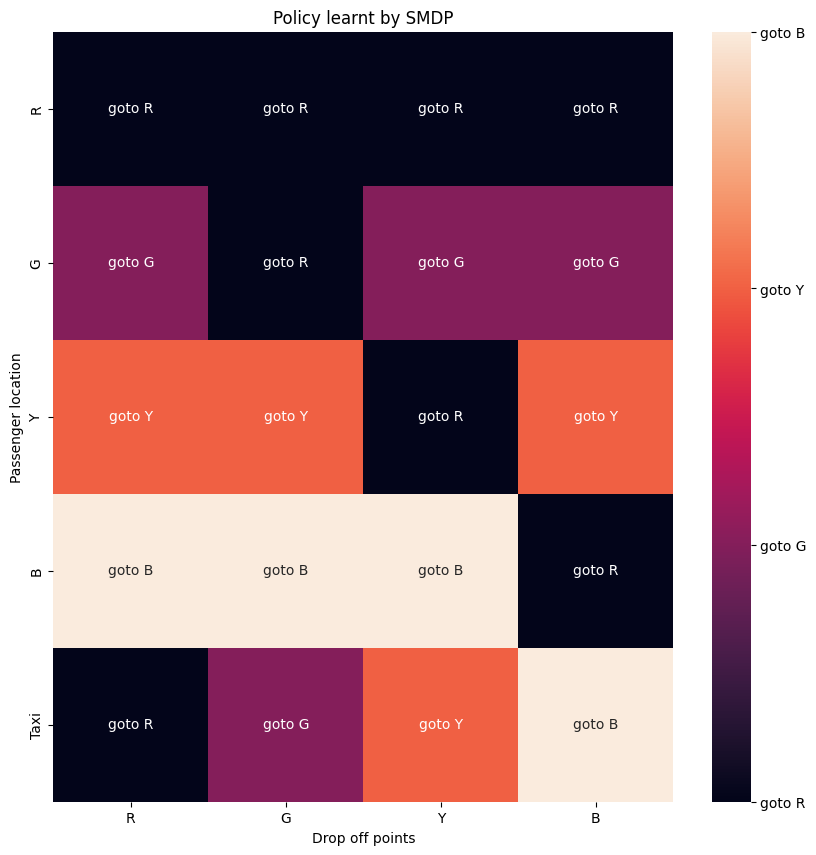

In [57]:
#@title : P(option | Passanger location, Destination) = max. over all options ( Q( option | Passanger location, Destination ) )
Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)

labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

## Task 2 : Intra-Option Q-learning

### Learning para

In [58]:
def Sub(state, passanger_actions = 5, destination_actions = 4):
  _,_,pas,drop = env.decode(state)
  subState = destination_actions*pas+drop
  return subState

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
#@title Iterating on episodes
reward_list_2 = []
# T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}



# Add parameters you might need here
gamma = 0.9
alpha = 0.1

nX = 5; nY = 5; passanger_actions = 5; destination_actions = 4
q_values_IOQL = np.zeros((passanger_actions*destination_actions,option_num))
updates_IOQL = np.zeros((passanger_actions*destination_actions,option_num))

option_Q_value = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(option_num)}


eps = {i:0.01 for i in range(option_num)}
eps_min, eps_decay, eps_main, count = 0.01, 0.99, 0.5, 0

episodes = 1500

# episodes
for i in range(episodes):
  #initializing total reward for each iteration to zero
    total_reward=0
    state = env.reset()
    on_terminal = False

    # While episode is not over
    while not on_terminal:

        # Choose action
        _,_,pas,drop = env.decode(state)
        subState = destination_actions*pas+drop
        action = egreedy(q_values_IOQL, subState, eps=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)


        option = action
        option_done = False
        prev = state
        while not option_done and not on_terminal:

            # Think about what this function might do?
            # Option()
            optact,option_done = Option(env,state,option,option_Q_value,eps[option])
            next_state, reward, on_terminal,_ = env.step(optact)

            total_reward+=reward


            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state))
            [x1,y1,_,_]=  list(env.decode(next_state))



            eps[option] = max(eps_min,eps_decay*eps[option])
            total_reward+=reward
            reward_surr = reward
            if option_done:
              reward_surr = 20
            if optact<4:
              option_Q_value[option][5*x+y, optact] = option_Q_value[option][5*x+y, optact] + \
                                          alpha*(reward_surr + gamma*np.max(option_Q_value[option][5*x1+y1, :]) - option_Q_value[option][5*x+y, optact])



            #finding all options giving same action call

            for o in range(option_num):
              optact_o,option_done_o = Option(env,state,o,option_Q_value,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if option_done_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o])

                updates_IOQL[Sub(state), o] += 1
            state = next_state

    reward_list_2.append(total_reward)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (1484/1500) = 98.93333333333334%


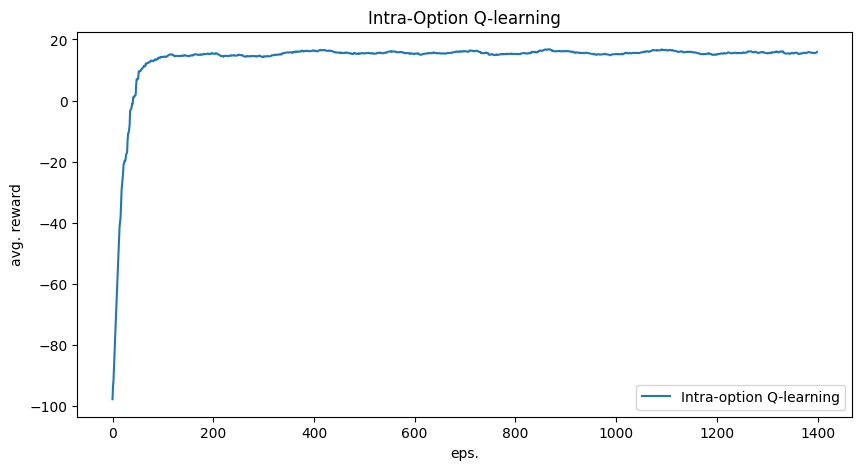

In [60]:
#@title : plotting iteration vs avg.reward (while learning)
plt.figure(figsize = (10,5))
avg_rews2 = [np.average(reward_list_2[i:i+100]) for i in range(len(reward_list_2)-100)]
plt.plot(avg_rews2,label = 'Intra-option Q-learning')
plt.xlabel('eps.')
plt.ylabel('avg. reward')
plt.title('Intra-Option Q-learning')
plt.legend()

### Learned Parameters

In [61]:
q_values_IOQL # Selecting an option

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  1.7270478 ,  -6.18952882,  -9.55713921,  -7.13683439],
       [  3.16456319,  -8.26608739,  -9.7181737 ,  -8.46831263],
       [  2.36507683,  -5.86671128,  -9.41547305,  -7.43405872],
       [ -8.06580365,   2.23180038,  -8.51553938,  -8.04776603],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -5.7332127 ,   2.06533205,  -6.58833938,  -7.76179366],
       [ -6.68861645,   2.15591556,  -8.34407638,  -9.10883416],
       [-10.02952999,  -9.3671219 ,   2.78562923,  -9.22903911],
       [ -9.89277594,  -8.80518025,   1.13691562,  -8.78665444],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -9.81118022,  -8.70812067,   2.69693374,  -8.90417094],
       [ -9.16129202,  -9.51256406,  -9.18122711,   2.70955484],
       [ -6.13396111,  -8.03708486,  -8.08495026,   2.51549018],
       [ -6.29414219,  -8.11443155,  -7.78548213,   3.69300872],
       [  0.        ,   0

In [62]:
option_Q_value # selecting a action form an option

{0: array([[ 0.        , 82.59264361,  0.        ,  0.        ],
        [-0.1       , -0.1       , -0.1       , 57.81393646],
        [32.70204256, -1.819101  , -1.82589295, -1.82093062],
        [21.3294324 , -2.06385716, -2.05607964, -2.03766536],
        [29.7529669 , -2.45280713, -2.45280713, -2.41640389],
        [13.4140622 , 73.33337925, -0.109     , -0.1       ],
        [-0.33474166, -0.2638    , -0.29701   , 55.84048408],
        [44.67447133, -1.51674944, -1.53985615, -1.48542229],
        [-1.74006547, -1.77907161, -1.74167252, 39.20129055],
        [-2.00327159,  0.50120486, -1.9836941 , 34.2489708 ],
        [13.31743112, 65.00004133,  4.53707786, 10.60583458],
        [ 2.49222268, 11.46533778, -0.66350796, 57.50003719],
        [ 4.66084444, -1.21719636, -0.6562481 , 50.75003341],
        [-1.57257573, -1.5986881 , -0.66605207, 44.67484697],
        [-1.78870532, -1.80303499, -1.82093062, 27.11886267],
        [-0.72776955, 57.49817077, -0.67934652, -0.67934652],
     

### score/reward on learned parameters

In [63]:
#@title : iterating

reward_list_2 = []
# T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}



# Add parameters you might need here
gamma = 0.9
alpha = 0.1

nX = 5; nY = 5; passanger_actions = 5; destination_actions = 4
# q_values_IOQL = np.zeros((passanger_actions*destination_actions,option_num))
# updates_IOQL = np.zeros((passanger_actions*destination_actions,option_num))

# option_Q_value = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(option_num)}


eps = {i:0.01 for i in range(option_num)}
eps_min, eps_decay, eps_main, count = 0.01, 0.99, 0.5, 0

episodes = 1500

# episodes
for i in range(episodes):
  #initializing total reward for each iteration to zero
    total_reward=0
    state = env.reset()
    on_terminal = False

    # While episode is not over
    while not on_terminal:

        # Choose action
        _,_,pas,drop = env.decode(state)
        subState = destination_actions*pas+drop
        action = egreedy(q_values_IOQL, subState, eps=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)


        option = action
        option_done = False
        prev = state
        while not option_done and not on_terminal:

            # Think about what this function might do?
            # Option()
            optact,option_done = Option(env,state,option,option_Q_value,eps[option])
            next_state, reward, on_terminal,_ = env.step(optact)

            total_reward+=reward


            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state))
            [x1,y1,_,_]=  list(env.decode(next_state))



            eps[option] = max(eps_min,eps_decay*eps[option])
            total_reward+=reward
            reward_surr = reward
            if option_done:
              reward_surr = 20
            if optact<4:
              # option_Q_value[option][5*x+y, optact] = option_Q_value[option][5*x+y, optact] + \
              #                             alpha*(reward_surr + gamma*np.max(option_Q_value[option][5*x1+y1, :]) - option_Q_value[option][5*x+y, optact])
              pass



            #finding all options giving same action call

            # for o in range(option_num):
            #   optact_o,option_done_o = Option(env,state,o,option_Q_value,eps[o])
            #   if optact_o == optact:
            #     eps[o] = max(eps_min,eps_decay*eps[o])
            #     if option_done_o:
            #       q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
            #     else:
            #       q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o])

            #     updates_IOQL[Sub(state), o] += 1
            state = next_state

    reward_list_2.append(total_reward)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

Success (1500/1500) = 100.0%


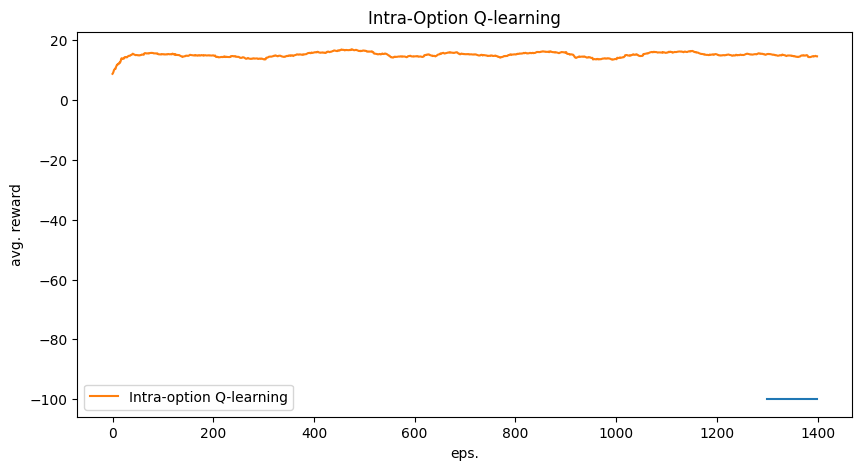

In [64]:
#@title : plotting score ( on learned parameters )
plt.figure(figsize = (10,5))
avg_rews2_1 = [np.average(reward_list_2[i:i+100]) for i in range(len(reward_list_2)-100)]
plt.plot(X,[-100 for i in range(100)])
plt.plot(avg_rews2_1,label = 'Intra-option Q-learning')
plt.xlabel('eps.')
plt.ylabel('avg. reward')
plt.title('Intra-Option Q-learning')
plt.legend()

### Visualizing Policy

Text(0.5, 1.0, 'Policy over default actions learnt by Intra Options')

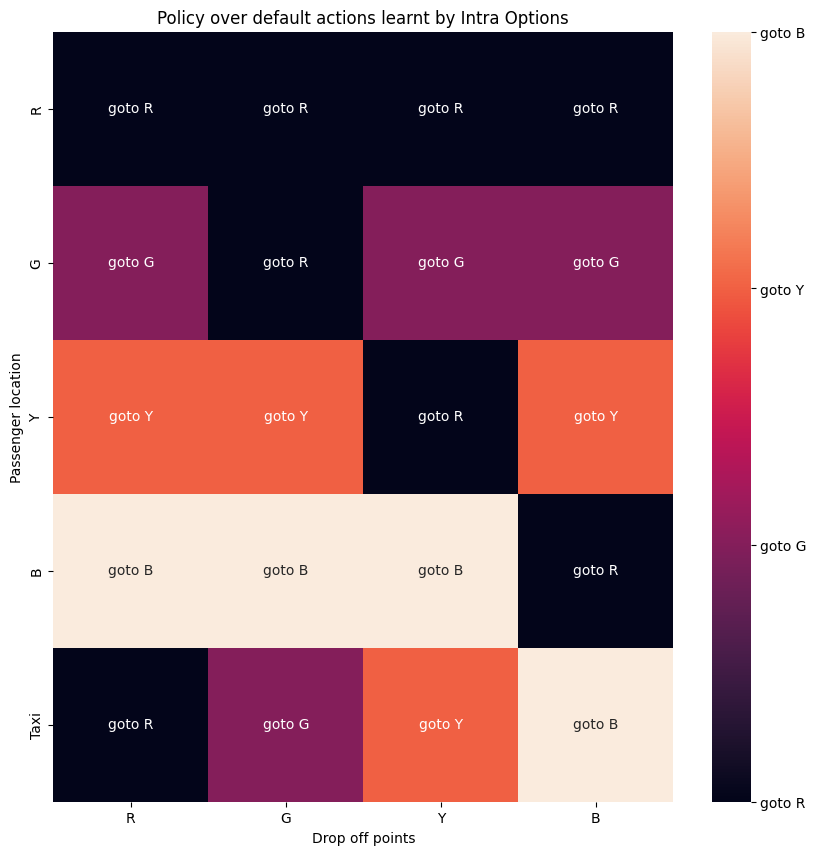

In [65]:
#@title : visualizing policy
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_IOQL)

figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
#c_bar.set_ticklabels(['south','north','east','west','pick up','drop'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over default actions learnt by Intra Options')

## Task 3 : Other *options*

Yes, there are other possible *options* besides what I have defined earlier for reachingR, eachingG, reachingY, & reaching B in *Defining options:* section of this notebook.

Step:1 define new options for each objective (reaching R, G and so one )

step 2: Run the algo. with already learned parameters, as done in *Score/reward on learned parameters* section of each Task1 and Task2. (without updating parameters in the algorithm)

## Task 4: comparing SMDP & IOQL

here avg reward is calculated as done in all earlier cases - avg. of reward of 100 previous episodes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


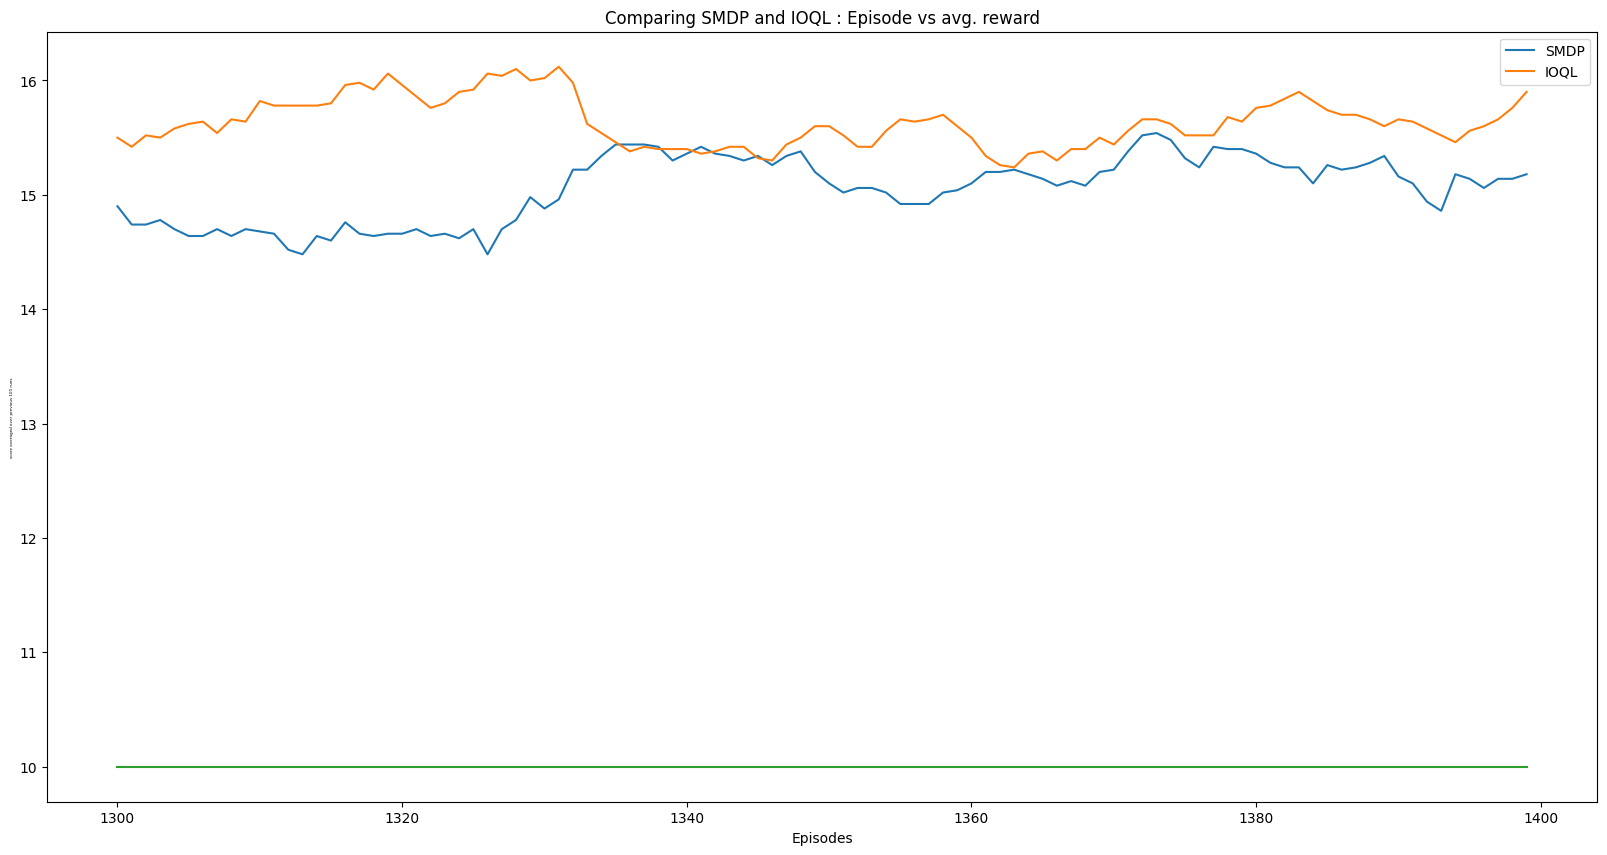

In [66]:
#@title Comparing SMDP-QL and IOQL

plt.figure(figsize = (20,10))
X = [i for i in range(len(avg_rews1)-100,len(avg_rews1))]
plt.plot(X,avg_rews1[-100:],label = 'SMDP')
plt.plot(X,avg_rews2[-100:],label = 'IOQL')
plt.plot(X,[10 for i in range(100)],)
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs', size=3)
plt.title('Comparing SMDP and IOQL : Episode vs avg. reward')
plt.legend()